In [ ]:
"""
This script processes a dataset ('original_dataset.csv'), containing columns 'text', 'tags', and 'text_len'. 

The following tasks are performed:

1. Loading and exploring the original dataset, checking for duplicates, missing values, dtypes.
2. Aggregating labels based on CFLW's taxonomy into broader abuse categories ('Financial Crime', 'Cybercrime', 'Drugs and Narcotics Trade', 'Weapons Trade', 'Violent Crime').
3. Filtering the dataset to keep only the relevant labels.
4. Analyzing the distribution of text lengths across different crime categories using descriptive statistics and visualization.
5. Examining the class distribution in the dataset using count plots.
6. Further cleaning steps:
   --> Removing phone numbers, email addresses, non-basic ASCII characters, uncommon punctuation, and specific patterns.
7. Removing instances with less than 10 words.
8. Saving the preprocessed dataset to a new CSV file ('preprocessed_dataset.csv').

"""
# Note: Uncommenting the last .to_csv lines will overwrite the original CSV files.

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

Loading and exploring the original dataset

In [ ]:
df = pd.read_csv('data/original_dataset.csv') #dataset obtained from CFLW
df.groupby(by="tags").count() #checking individual tags

In [ ]:
df.info()
print(df.isna().sum()) 
#no null/nan values, all correct dtypes
print(df.duplicated(keep=False).sum()) 
#no duplicates detected

Label aggregation according to CFLW taxonomy

In [4]:
conditions = [(df["tags"] == "Gift Cards") | (df["tags"] == "Gambling") | (df["tags"] == "Credit Cards") |\
              (df["tags"] == "Credit Cards,Gift Cards"), (df["tags"] == "Leaked Data") | (df["tags"] == "Hacking,Leaked Data") |\
                 (df["tags"] == "Hacked Accounts,Leaked Data") | (df["tags"] == "Hacking") |\
                 (df["tags"] =="Hacked Accounts,Hacking") | (df["tags"] == "Hacked Accounts"),\
                  (df["tags"] == "Drugs / Narcotics"), \
                    (df["tags"] == "Hitman"),\
                      (df["tags"] == "Weapons")]
classes = ["Financial Crime", "Cybercrime", "Drugs and Narcotics Trade", "Violent Crime", "Weapons Trade"]
df["label"] = np.select(conditions, classes, default= "") 
df= df[df.label.isin(classes)] 
#dataset is filtered to keep only relevant classes, 
#tags belonging to multiple categories (around 10%) are excluded

Text length distribution

In [ ]:
df.describe()

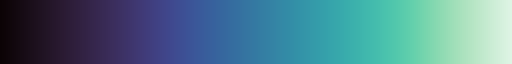

In [6]:
sns.set(rc={'figure.figsize':(8,6)})
sns.color_palette("mako", as_cmap=True)

Text(0, 0.5, 'Text length')

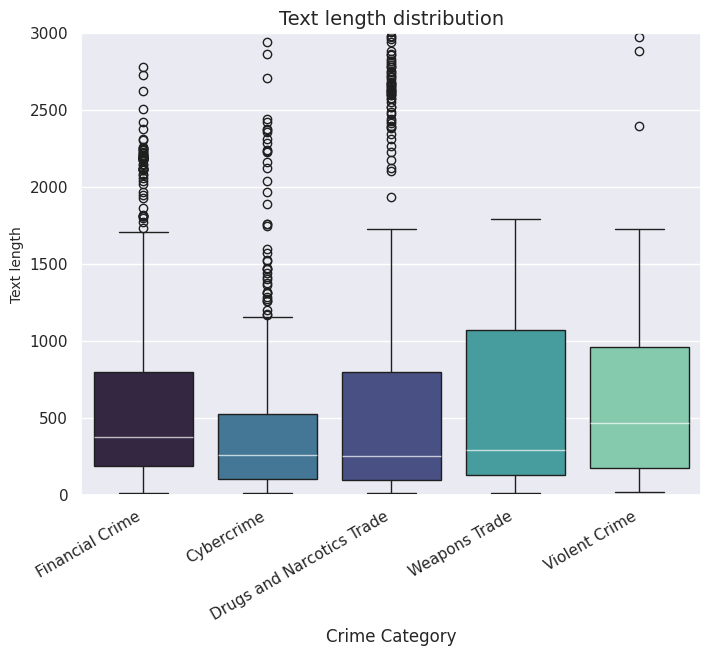

In [7]:
sns.boxplot(data=df, y = 'text_len', x= 'label', hue='label', palette='mako', medianprops=dict(color="white", alpha=0.7), order=["Financial Crime", "Cybercrime", "Drugs and Narcotics Trade", "Weapons Trade", "Violent Crime"])
plt.xticks(rotation=30,ha='right')
plt.title("Text length distribution", fontsize = 14)
plt.suptitle("")
plt.ylim(0,3000)
plt.xlabel('Crime Category', fontsize = 12)
plt.ylabel('Text length', fontsize = 10)

In [ ]:
df.text_len[(df.text_len <= 400)].count() #58% of the observations is below the threshold of 512 tokens (approximated to 400 words)

Class distribution

In [ ]:
df.groupby("label")['text'].count()

Text(0.5, 1.0, 'Class imbalance')

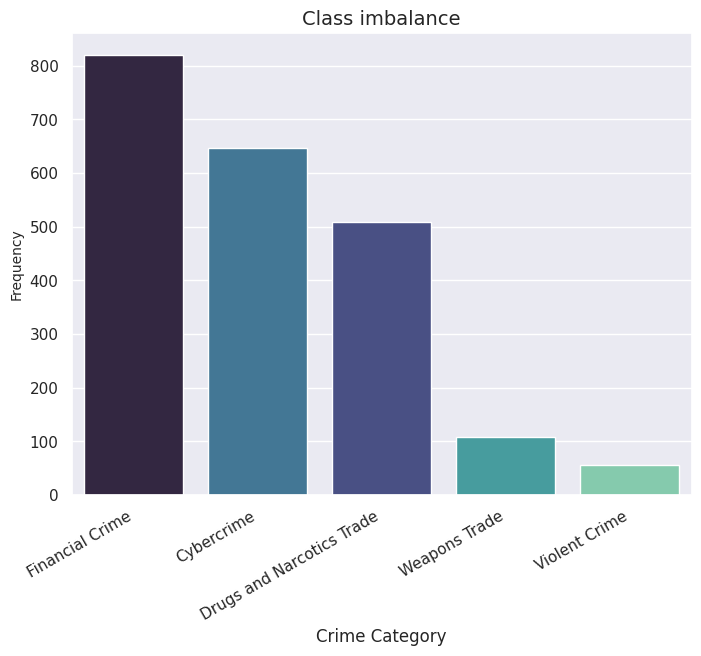

In [10]:
sns.countplot(data=df, x= "label", hue="label", palette="mako",order=["Financial Crime", "Cybercrime", "Drugs and Narcotics Trade", "Weapons Trade", "Violent Crime"])
plt.xticks(rotation=30,ha='right')
plt.xlabel('Crime Category', fontsize = 12)
plt.ylabel('Frequency', fontsize = 10)
plt.title('Class imbalance', fontsize = 14)

Further cleaning steps

In [11]:
df['text'] = df['text'].apply(lambda text: re.sub(r'\b(?:\+\d{1,2}\s?)?\(?(?:\d{1,4})?\)?[-.\s]?\d{1,5}[-.\s]?\d{1,5}[-.\s]?\d{1,9}\b', '', text)) #removes phone numbers
df['text'] = df['text'].apply(lambda text: re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b', '', text)) #removes email addresses

In [12]:
df['text'] = df['text'].apply(lambda text: re.sub(r'[^\x00-\x7F]+', '', text)) #removes non basic ASCII character, to remove non English characters
df['text'] = df['text'].apply(lambda text: re.sub(r'[^\w\s.?!,:;\'"\d-]', '', text)) #removes uncommon punctuation

In [13]:
df['text'] = df['text'].apply(lambda x: x.replace('.onion', ''))
df['text'] = df['text'].apply(lambda x: x.replace(r'(?i).JS', ''))
df['text'] = df['text'].apply(lambda x: re.sub(r'(?i)www', '', x))
df['text'] = df['text'].apply(lambda x: x.replace('\r', ''))
#removes .onion, .JS Www \r --> all patterns detected from the previous cleaning activities

In [14]:
df['text_len'] = df['text'].apply(lambda x: len(x.split()))
df = df[df.text_len >= 10].copy() #remove instances of less than 10 words

Class and text length distribution after preprocessing

In [ ]:
df['text_len'].describe()

In [19]:
#df.to_csv("data/preprocessed_dataset.csv")